# Houston, we have a Salary!
### Prediciting Annual Salaries of current Texas Government Employees
_by Mariam Naqvi, Christopher Mayorga, Forrest McCrosky and Desiree McElroy_

### Executive Summary
The goal of this analysis is to predict annual salary for current Texas government employees. This can help reduce the disparity in compensation among employees of different gender and races. This can lead to greater employee satisfaction and reduce employee turnover which could help employers reduce spending on hiring, recruitment and onboarding costs.

We acquired salary data for current employees of the Texas state government from the Texas Tribune's website. This data is available to the public and can be accessed here.

The data was cleaned extensively in preparation for analysis and modeling. Some steps taken during prepartion included dropping unnecessary columns and removing extra white space from column names. We also utilized feature engineering to create new features that could help improve model performance. 

After individual variable exploration, the dataset was split into train, validate and test sets. All bivariate and multivariate exploration,statistical testing as well as modeling were performed only on the train split to maintain data integrity and avoid data leakage. 

Since our target variable `annual_salary` is continuous, we created regression models to predict it. We utilized the following regression algorithms:
- OLS Linear Regression 
- Lasso Lars
- Tweedie Regressor GLM
- Polynomial Regression (2nd degree)

Recursive feature elimination was utilized to select the top 7 features to be included in the models used to predict annual salaries. 

Each model's performance was evaluated by measuring the RMSE and R-squared. The RMSE was utilized because it has the same units as our target variable and R-squared was used to evaluate how much of the variance in the data is captured by our models.

Our best performing model used Polynomial Regression and was fit on the test data. The model had the lowest RMSE and the highest R-squared on the test split indicating our model was not overfit. 

### Project Overview
- Our tasks were planned using this [Trello board.](https://trello.com/b/izaNBd0G/capstone-project)
- Python scripts were used to automate the process of acquiring, preparing and exploring the data.
- The data was cleaned by dropping duplicates and certain columns, encoding new features and one hot encoding features.
    - These steps were taken to create the best performing model
- Outliers in the data were analyzed as well as the distributions of variables explored in depth.
- The tenure variables were scaled using a min max scaler.
- Statistical analyses tested the following hypotheses:
    - There is a significant correlation between is_director and annual_salary
    - There is a significant correlation between tenure_months and annual_salary
    - There is a significant difference in annual salary between BIPOC and white Texas government employees 
    - Male employees have higher annual salaries than female employees.
    - Elected officials have higher salaries
    - Unclassified employees have higher salaries than classified positions 


### Key Takeaways
- The race and tenure encoded features were found to be the best drivers of annual salary.
- Some of the variables were highly correlated with each other.
- Average annual salary for employees of the 
- Elected officials had higher salaries than non elected officials.
- Most employees of the Texas government are white.
- Employees who are white or asian have higher than average annual salaries.
- Black employees have the lowest annual salaries.
- There are more female employees than male.
    - Most female employees have lower paying jobs.
    - Women are paid less than their male coworkers.
- Most elected officials are males.
- Most employees in director roles are males.

### Data Dictionary
- You can find the data dictionary detailing all the variables used and created [here.](https://github.com/Texas-Government-Employee-Salaries/Predicting-Salaries/blob/master/readme.md)


### Imports that will be utilized throughout this notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# custom module imports
import Acquire as aq
import Prepare as pr
import Explore as ex
import model as m

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

# import scaling methods
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split

# import modeling methods
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from scipy import stats

# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

## Acquire 

The dataset was acquired from the [Texas Tribune's website](https://salaries.texastribune.org/) and downloading all the data as a csv file. We will read in the csv as a Pandas dataframe using functions from the Acquire script.

The Acquire script contains functions to obtain the data, cache it as well as provide summary statistics.

In [2]:
# read data as df
df = aq.get_texas_data()

In [3]:
# quick look at data 
df.head()

,AGY,NAME,LASTNAME,FIRSTNAME,MI,JOBCLASS,JC TITLE,RACE,SEX,EMPTYPE,...,RATE,HRSWKD,MONTHLY,ANNUAL,STATENUM,duplicated,multiple_full_time_jobs,combined_multiple_jobs,summed_annual_salary,hide_from_search
0,101,SENATE,GILLIAM,STACEY,L,7101,LEG. OFFICIAL/ADMINISTRATOR,WHITE,FEMALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,0.0,20.0,8100.0,97200.0,339371,True,NaN,NaN,181200.0,NaN
1,104,LEGISLATIVE BUDGET BOARD,GILLIAM,STACEY,L,C160,COMMITTEE DIRECTOR,WHITE,FEMALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,0.0,20.0,7000.0,84000.0,339371,True,NaN,NaN,NaN,True
2,101,SENATE,NELSON,DAVID,,7101,LEG. OFFICIAL/ADMINISTRATOR,WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,0.0,20.0,9500.0,114000.0,193187,True,NaN,NaN,210000.0,NaN
3,104,LEGISLATIVE BUDGET BOARD,NELSON,DAVID,,P080,SENIOR BUDGET ADVISOR,WHITE,MALE,URP - UNCLASSIFIED REGULAR PART-TIME,...,0.0,20.0,8000.0,96000.0,193187,True,NaN,NaN,NaN,True
4,101,SENATE,ROCHA,MARIE,S,7103,LEG. SERVICE/MAINTENANCE,HISPANIC,FEMALE,URF - UNCLASSIFIED REGULAR FULL-TIME,...,0.0,41.0,3365.4,40384.8,152257,True,NaN,True,NaN,NaN


In [4]:
# look at all columns in df
df.columns

Index(['AGY', 'NAME', 'LASTNAME', 'FIRSTNAME', 'MI', 'JOBCLASS', 'JC TITLE',
       'RACE', 'SEX', 'EMPTYPE', 'HIREDT', 'RATE', 'HRSWKD', 'MONTHLY',
       'ANNUAL', 'STATENUM', 'duplicated', 'multiple_full_time_jobs',
       'combined_multiple_jobs', 'summed_annual_salary', 'hide_from_search'],
      dtype='object')

In [5]:
# Check the different classes in each variable
df.nunique()

AGY                           111
NAME                          111
LASTNAME                    38227
FIRSTNAME                   23267
MI                             28
JOBCLASS                     1474
JC TITLE                     1406
RACE                            6
SEX                             2
EMPTYPE                         9
HIREDT                       6257
RATE                          207
HRSWKD                         47
MONTHLY                     39035
ANNUAL                      39037
STATENUM                   144727
duplicated                      1
multiple_full_time_jobs         1
combined_multiple_jobs          1
summed_annual_salary           11
hide_from_search                1
dtype: int64

- Displaying value_counts for the following will be helpful as these variables seem to have a few classes:
    - `RACE`
    - `SEX`
    - `EMPTYPE`
- Other variables besides the above seem to be continuous.

In [6]:
# summarize the df and its columns
aq.get_data_summary(df)

The dataframe has 144738 rows and 21 columns.

-------------------
There are total of 723537 missing values in the entire dataframe.

-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144738 entries, 0 to 144737
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   AGY                      144738 non-null  int64  
 1   NAME                     144738 non-null  object 
 2   LASTNAME                 144738 non-null  object 
 3   FIRSTNAME                144738 non-null  object 
 4   MI                       144738 non-null  object 
 5   JOBCLASS                 144738 non-null  object 
 6   JC TITLE                 144738 non-null  object 
 7   RACE                     144738 non-null  object 
 8   SEX                      144738 non-null  object 
 9   EMPTYPE                  144738 non-null  object 
 10  HIREDT                   144738 non-null  object 
 11  RATE           

## Takeaways

- The dataframe has a nice set of observations.
- Annual salary is our target variable
- Very few values in duplicated, multiple_full_time_jobs, combined_multiple_jobs and summed_annual_salary. There are no null values in any other columns
- Each observation is an employee for the Texas State Government.
- AGY column is the id for the department the employee works with.
- Most variables are upper case which should be converted to lower case.
- The column `MONTHLY` is the monthly salary.
    - The target variable `ANNUAL` is derived from this column.
- Most variables are object data types and would need to be one hot encoded in order to be utilized for modeling.
- Highest annual salary is 553,500 USD while the minimum is 600 USD.
- Max hours worked is 80 while minimum is 2.
- Highest proportion of employees is white and the lowest proportion are Native Americans.
- There are more females than males in the dataset.
- Most employees are classified regular full time.

## Prepare

During this phase of the pipeline, the main focus was on cleaning and preparing the data for analysis and modeling.

Functions from our prepare script were utilized to perform the following actions:

- drop duplicate rows
- change column names to lower case and remove white space
- remove white space from columns with object dtypes
- drop the following columns as they do not provide any additional information or value
    - `statenum`
    - `jobclass`
    - `mi`
    -`rate` 
    -`duplicated`
    - `multiple_full_time_jobs`
    - `combined_multiple_jobs`
    -`summed_annual_salary`
    -`hide_from_search`
- rename columns for ease of workflow
- change hire date to date time format
- drop rows with erroneous futuristic hire dates
- one hot encode object dtype variables to create numeric features which can be utilized in models
- create bins for tenure in years
- split the dataframe into train, test and split tests

### Exploring Univariate Distributions

The explore_univariate function from our explore script is used to create bar plots for categorical variables and histograms and boxplot for continuous variables. We will perform univariate exploration to visualize inidvaidual variable distributions before we prepare and split the dataframe.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144738 entries, 0 to 144737
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   AGY                      144738 non-null  int64  
 1   NAME                     144738 non-null  object 
 2   LASTNAME                 144738 non-null  object 
 3   FIRSTNAME                144738 non-null  object 
 4   MI                       144738 non-null  object 
 5   JOBCLASS                 144738 non-null  object 
 6   JC TITLE                 144738 non-null  object 
 7   RACE                     144738 non-null  object 
 8   SEX                      144738 non-null  object 
 9   EMPTYPE                  144738 non-null  object 
 10  HIREDT                   144738 non-null  object 
 11  RATE                     144738 non-null  float64
 12  HRSWKD                   144738 non-null  float64
 13  MONTHLY                  144738 non-null  float64
 14  ANNU

In [8]:
df.nunique()

AGY                           111
NAME                          111
LASTNAME                    38227
FIRSTNAME                   23267
MI                             28
JOBCLASS                     1474
JC TITLE                     1406
RACE                            6
SEX                             2
EMPTYPE                         9
HIREDT                       6257
RATE                          207
HRSWKD                         47
MONTHLY                     39035
ANNUAL                      39037
STATENUM                   144727
duplicated                      1
multiple_full_time_jobs         1
combined_multiple_jobs          1
summed_annual_salary           11
hide_from_search                1
dtype: int64

In [9]:
cat_vars = ['RACE', 'SEX', 'EMPTYPE']
quant_vars = ['MONTHLY','ANNUAL']

Bar Plot of RACE


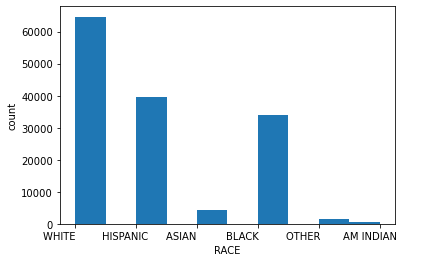

Bar Plot of SEX


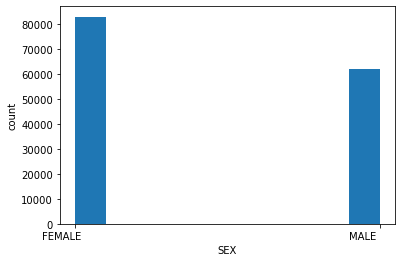

Bar Plot of EMPTYPE


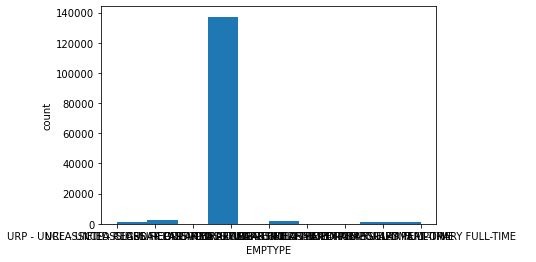

Distribution of MONTHLY


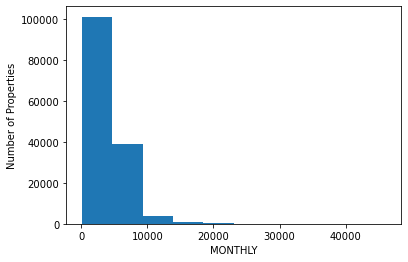

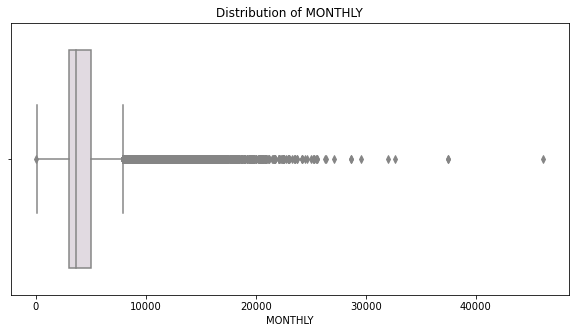

Distribution of ANNUAL


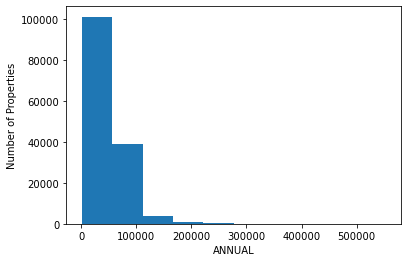

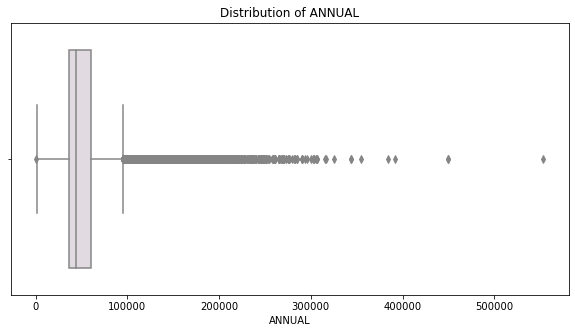

In [10]:
ex.explore_univariate(df, cat_vars, quant_vars)

### Takeaways

- Highest number of white employees
- There are more female employees than male
- Monthly and Annual Salary have right skewed distributions due to upper end outliers



Now we will call functions from our prepare script to prepare the data for further exploration and modeling.

In [11]:
df = pr.prepare_tex(df)

In [12]:
# create new encoded features
df = pr.create_features(df)

Looking At Our Maximum Age and Minimum Age to Make Some Age Bins

Max: 49.8, Min: 0.0

----------------------------

Visualizing Years of Tenure Column To Help with Binning



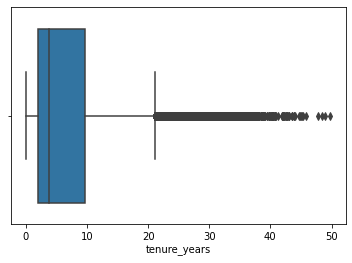


----------------------------

Looking At Our Years of Tenure Bins Value Counts
1    83012
2    27330
3    25513
4     8875
Name: tenure_years_bins, dtype: int64

----------------------------



In [13]:
# create bins for tenure
df = pr.make_bins_and_feats(df)

In [14]:
# look at prepared df with new features
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144730 entries, 0 to 144737
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   agency_id          144730 non-null  int64         
 1   agency             144730 non-null  object        
 2   lastname           144730 non-null  object        
 3   firstname          144730 non-null  object        
 4   title              144730 non-null  object        
 5   race               144730 non-null  object        
 6   sex                144730 non-null  object        
 7   emptype            144730 non-null  object        
 8   hire_date          144730 non-null  datetime64[ns]
 9   hours_worked       144730 non-null  float64       
 10  monthly_salary     144730 non-null  float64       
 11  annual_salary      144730 non-null  float64       
 12  is_female          144730 non-null  int64         
 13  is_white           144730 non-null  int64   

In [15]:
# split the df to prevent data leakage
train, validate, test = pr.split_data(df)

Making Sure Our Shapes Look Good
Train: (81048, 29), Validate: (34736, 29), Test: (28946, 29)


- The split dataframes have different number of rows but the same number of columns which is what we are looking for.

## Explore

### Bivariate Exploration

We will explore the interaction of variables using only on our train split.

In [16]:
# quick peak at train split
train.head()

,agency_id,agency,lastname,firstname,title,race,sex,emptype,hire_date,hours_worked,...,tenure_years,is_elected,is_director,is_unclassified,is_parttime,tenure_years_bins,0-5_years,5-10_years,10-20_years,>20_years
125096,696,TEXAS DEPARTMENT OF CRIMINAL JUSTICE,OKECHI,VICTOR,CORREC OFFICER IV,BLACK,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,2017-02-06,40.0,...,4.4,0,0,0,0,1,1,0,0,0
42845,529,HEALTH AND HUMAN SERVICES COMMISSION,EKRAM,NIDAA,PROGRAM SPECIALIST V,ASIAN,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,2020-09-08,40.0,...,0.8,0,0,0,0,1,1,0,0,0
117530,696,TEXAS DEPARTMENT OF CRIMINAL JUSTICE,ISIORHOVOJA,ANDREW,CORREC OFFICER IV,BLACK,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,2020-03-30,40.0,...,1.2,0,0,0,0,1,1,0,0,0
26227,405,DEPARTMENT OF PUBLIC SAFETY,NETT,ROBERT,"SERGEANT, DPS",WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,2009-09-27,40.0,...,11.8,0,0,0,0,3,0,0,1,0
113713,696,TEXAS DEPARTMENT OF CRIMINAL JUSTICE,GARZA,AMANDA,PAROLE OFFCR II,HISPANIC,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,2016-08-15,40.0,...,4.9,0,0,0,0,1,1,0,0,0


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81048 entries, 125096 to 89798
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   agency_id          81048 non-null  int64         
 1   agency             81048 non-null  object        
 2   lastname           81048 non-null  object        
 3   firstname          81048 non-null  object        
 4   title              81048 non-null  object        
 5   race               81048 non-null  object        
 6   sex                81048 non-null  object        
 7   emptype            81048 non-null  object        
 8   hire_date          81048 non-null  datetime64[ns]
 9   hours_worked       81048 non-null  float64       
 10  monthly_salary     81048 non-null  float64       
 11  annual_salary      81048 non-null  float64       
 12  is_female          81048 non-null  int64         
 13  is_white           81048 non-null  int64         
 14  i

In [18]:
# assign categorical and quantitative(continuous) variables
cat_vars1 = ['race','sex','is_female','is_white','is_hispanic','is_black','is_BIPOC','race_encoded',
           'is_elected','is_director','is_unclassified','is_parttime','tenure_years_bins','0-5_years',
           '5-10_years', '10-20_years', '>20_years']
quant_vars1 = ['agency_id','hours_worked','monthly_salary','annual_salary']

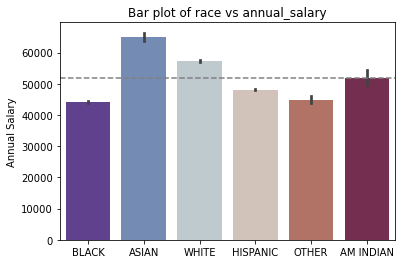

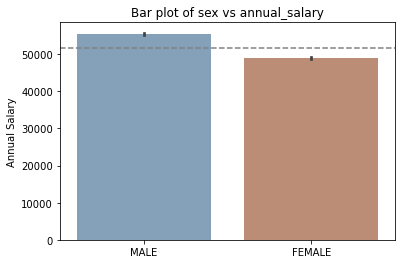

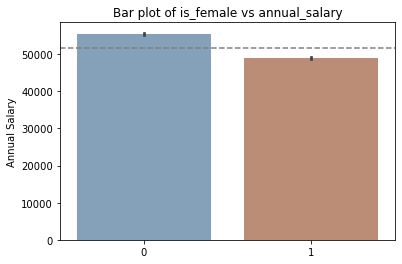

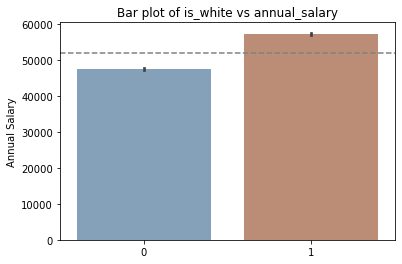

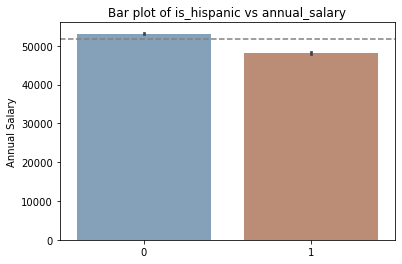

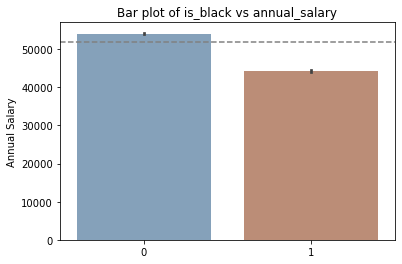

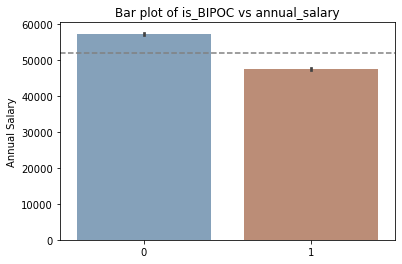

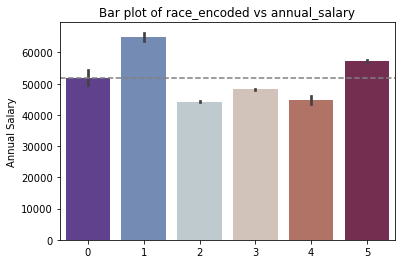

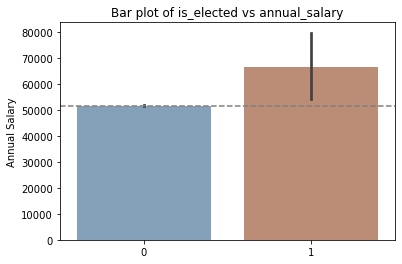

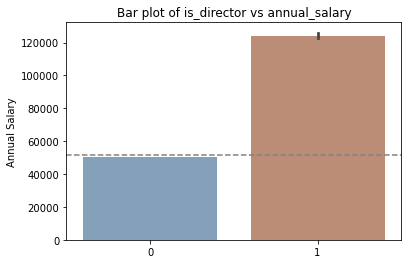

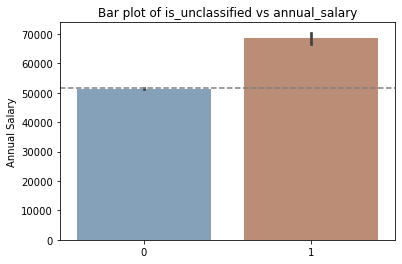

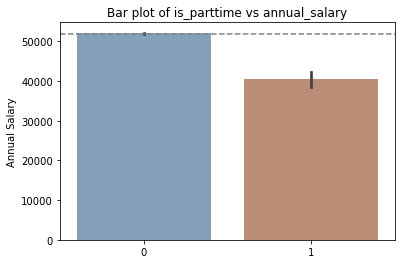

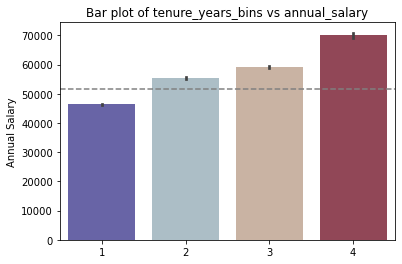

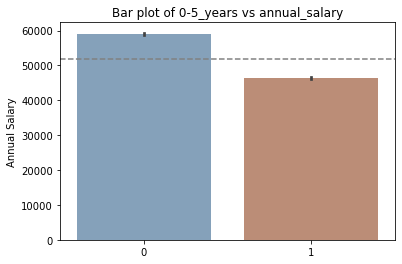

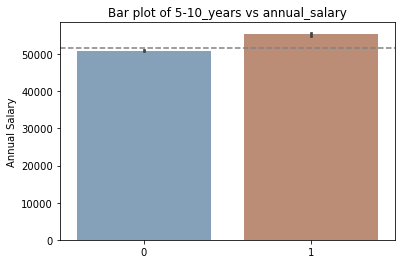

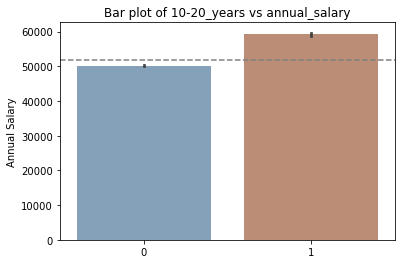

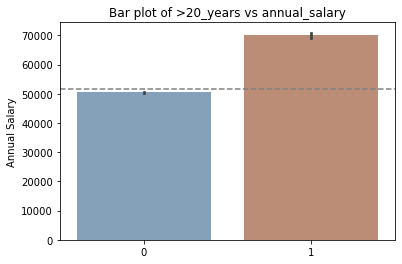

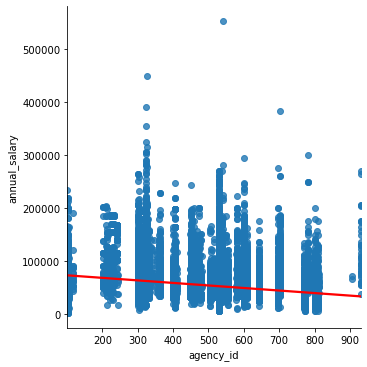

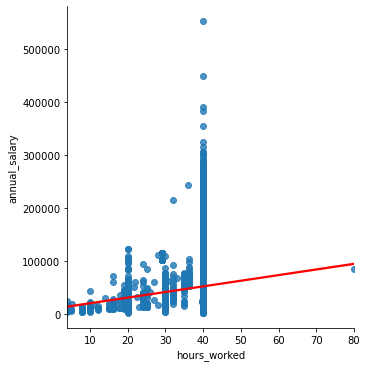

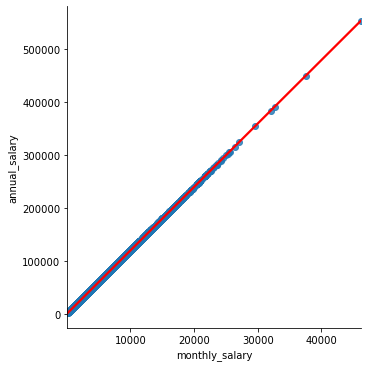

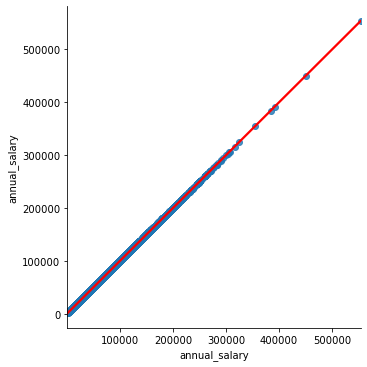

In [19]:
# call the function to create barplots and scatterplots
ex.explore_bivariate(train, 'annual_salary', cat_vars1, quant_vars1)

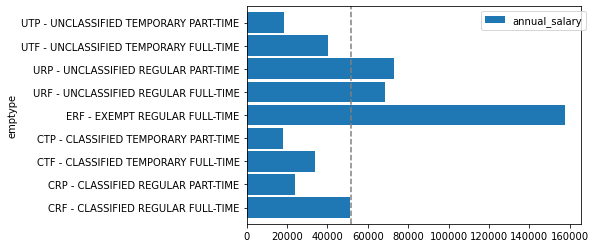

In [20]:
# to visualize emptype vs annual salary better
overall_mean = df['annual_salary'].mean()
pd.pivot_table(train, values='annual_salary', index='emptype').plot.barh(width=0.9)
plt.axvline(overall_mean, ls = '--', color = 'grey')
plt.legend(bbox_to_anchor=(1.03, 1))
plt.show()

### Takeaways

- Employees who are white or asian have annual salaries above the average
- Asians have the highest annual salary
- Black and other races seem to have the lowest annual salary
- Males have a higher annual salary than women
- Exempt regular full time employees have the highest annual salaries
- Unclassified Regular Employees have lower salaries than classified regular employees
- Elected employees have higher annual salary than non elected employees
- Employees with under 5 years' tenure have lower salaries than those who have longer tenures.

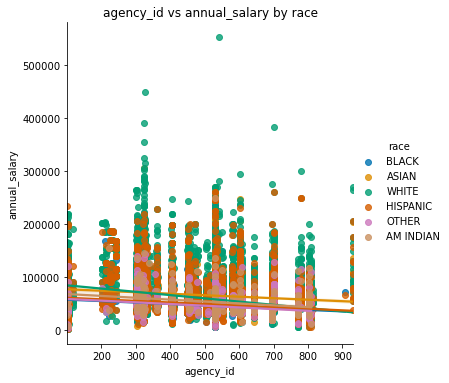

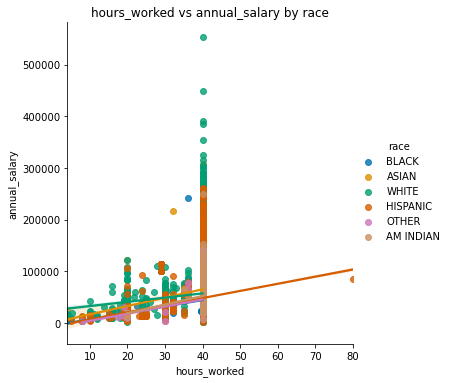

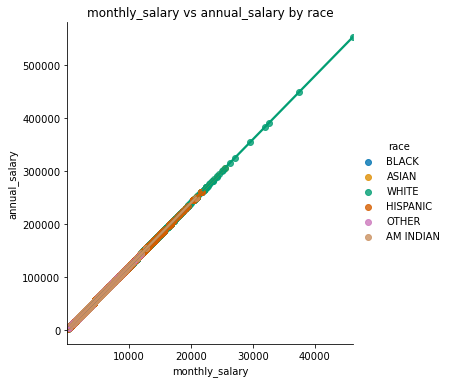

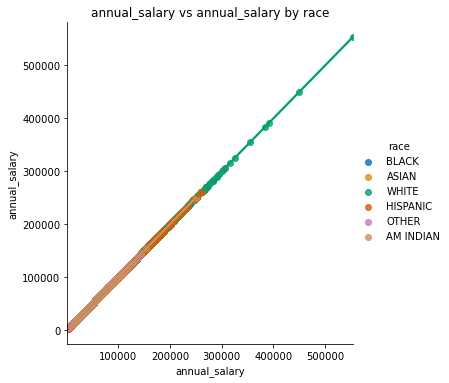

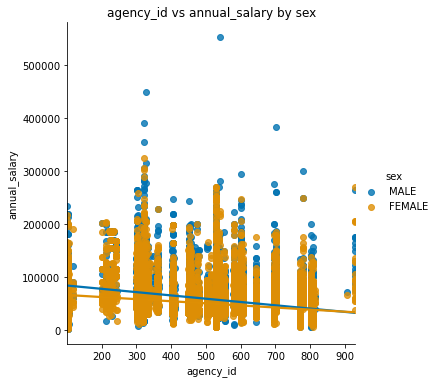

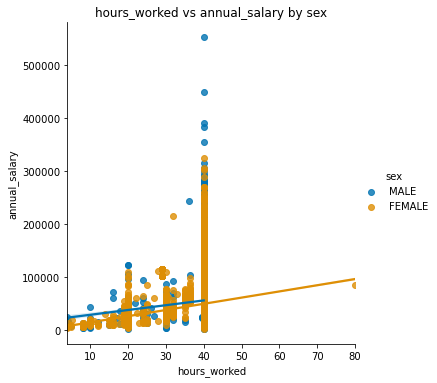

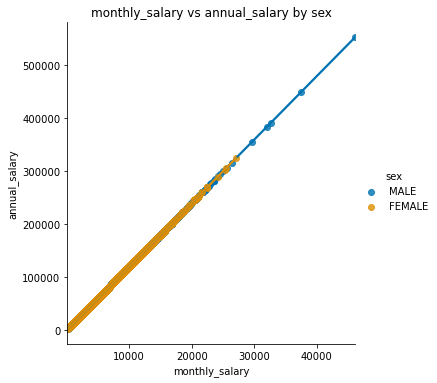

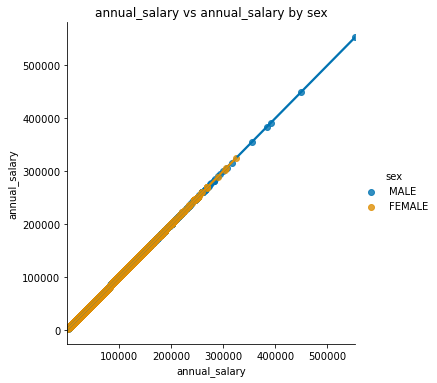

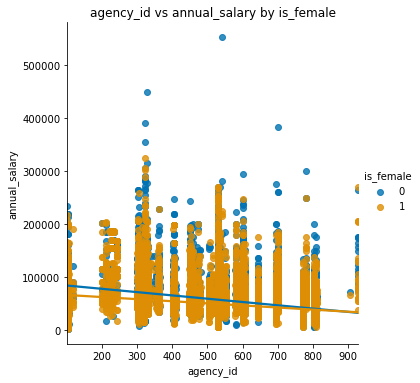

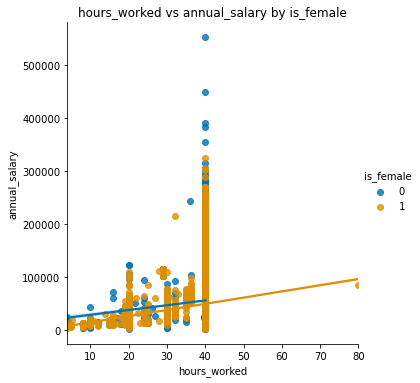

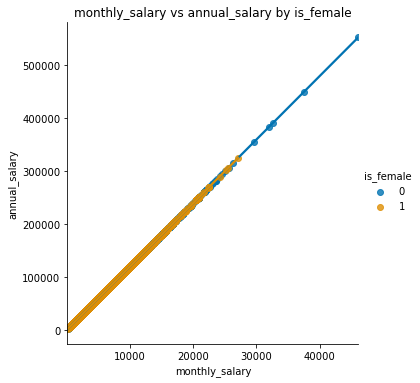

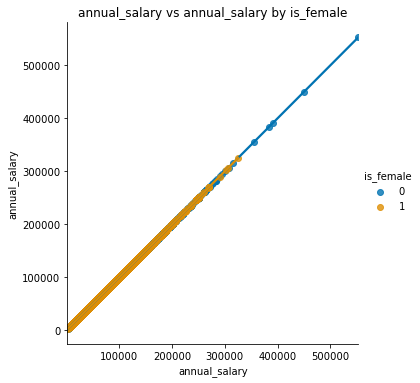

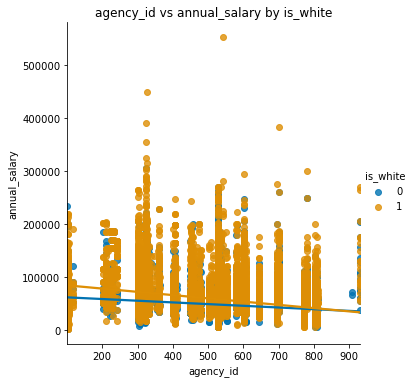

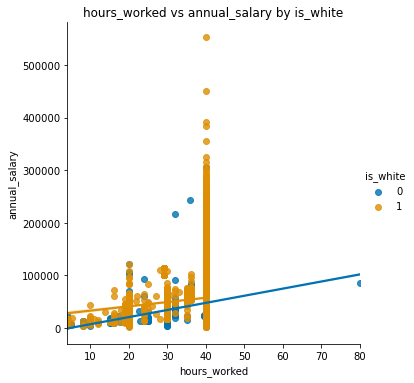

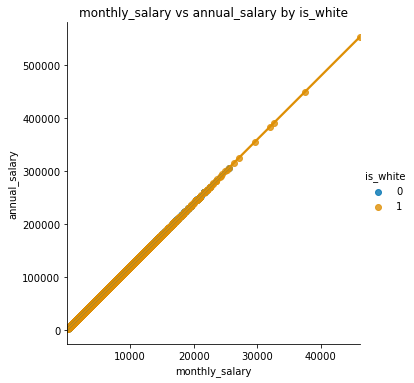

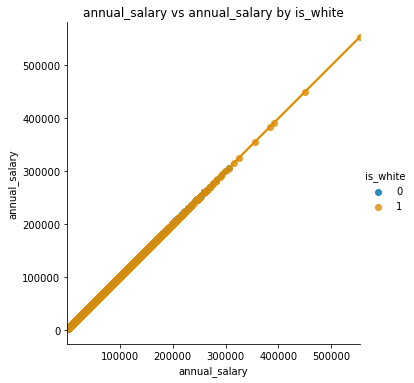

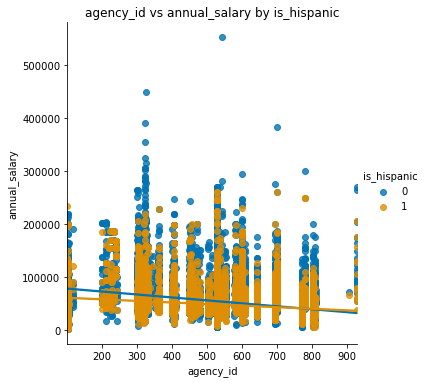

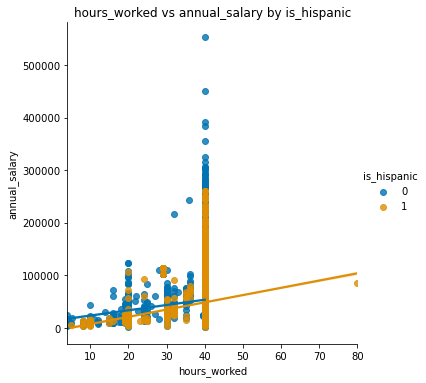

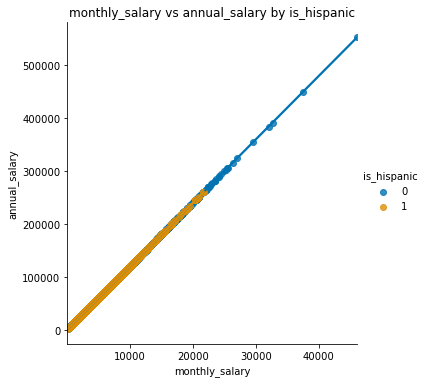

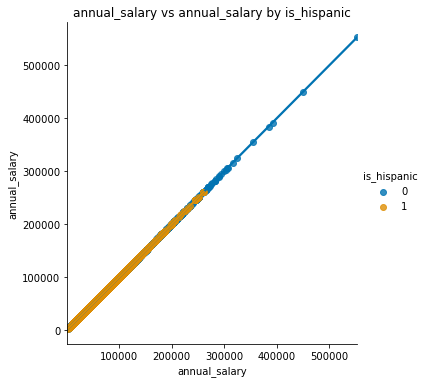

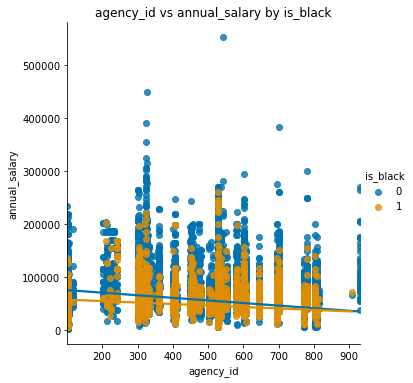

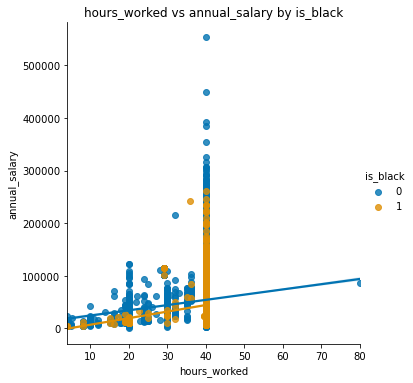

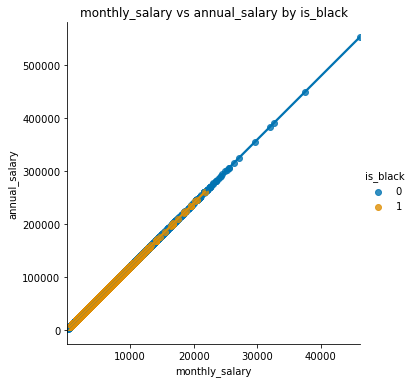

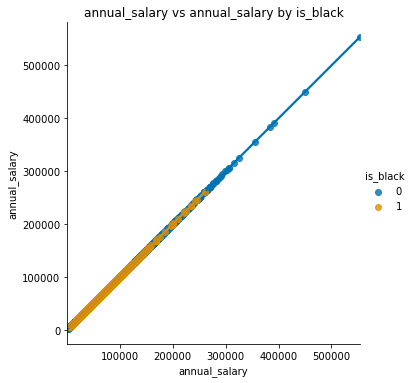

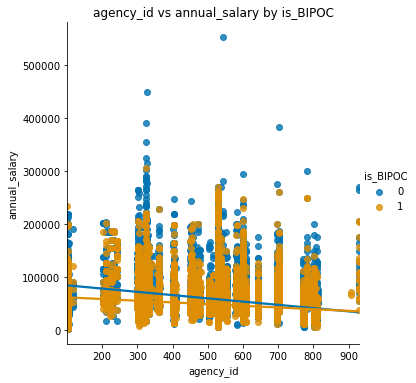

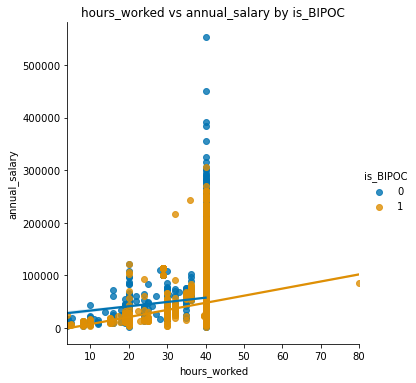

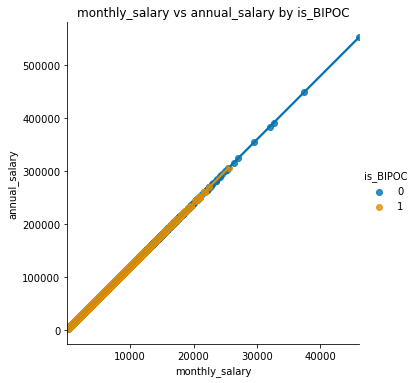

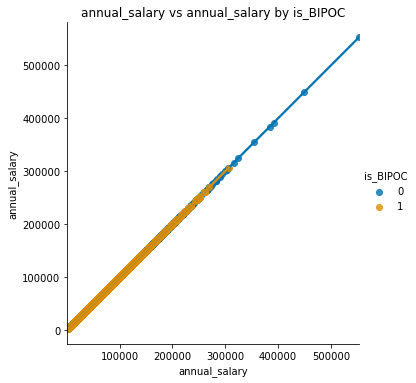

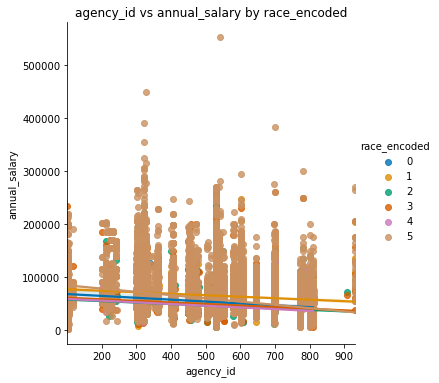

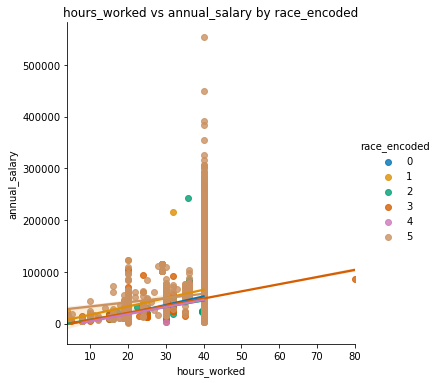

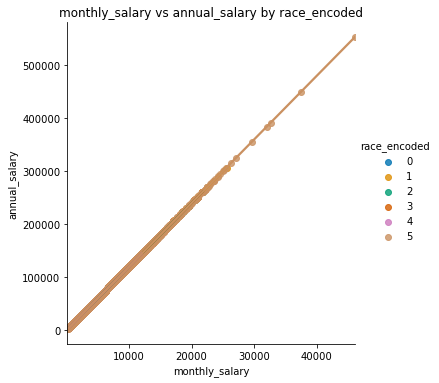

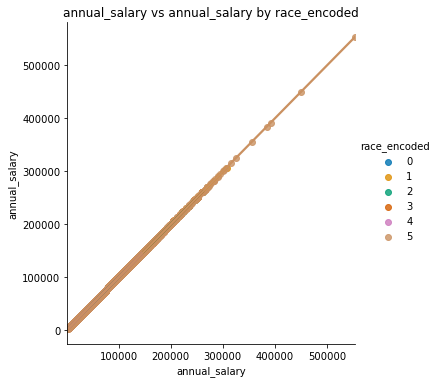

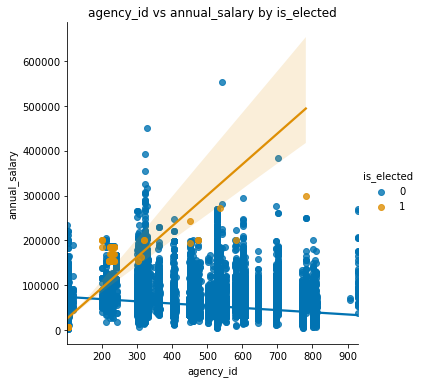

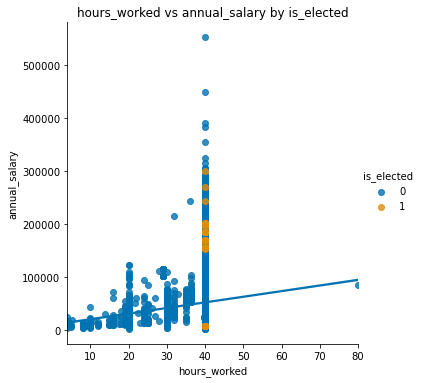

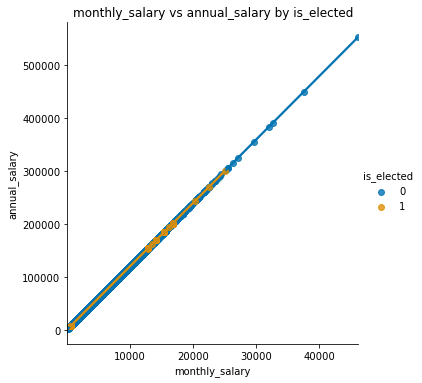

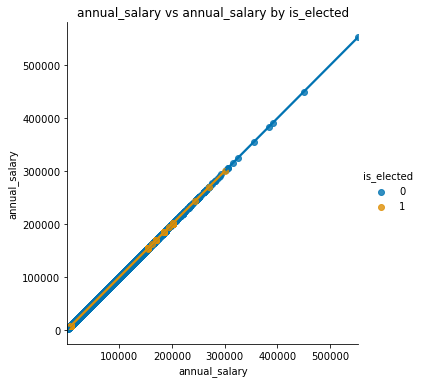

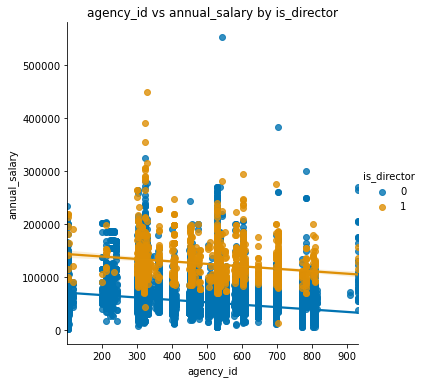

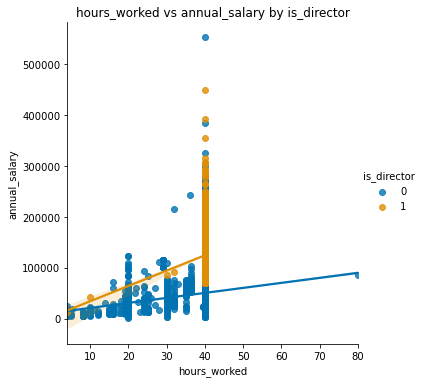

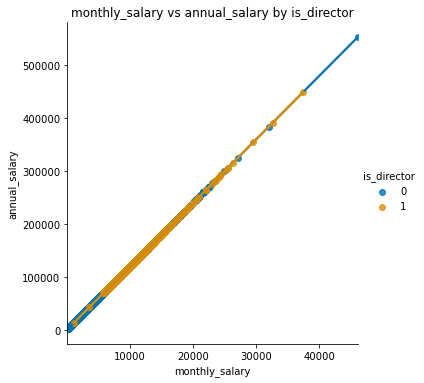

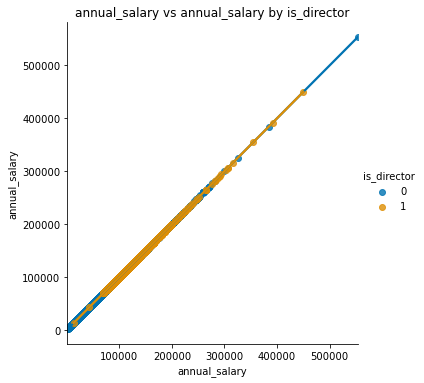

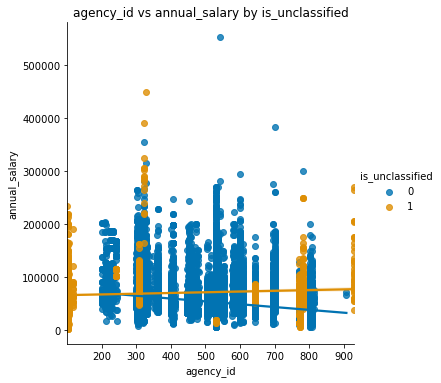

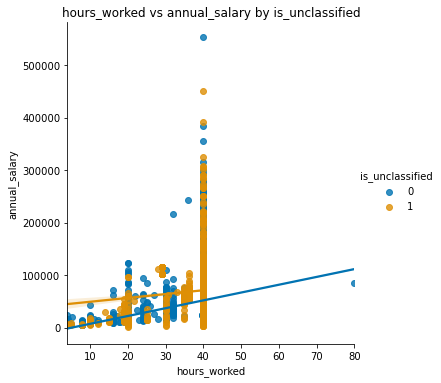

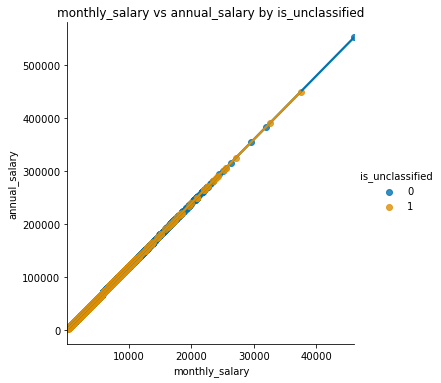

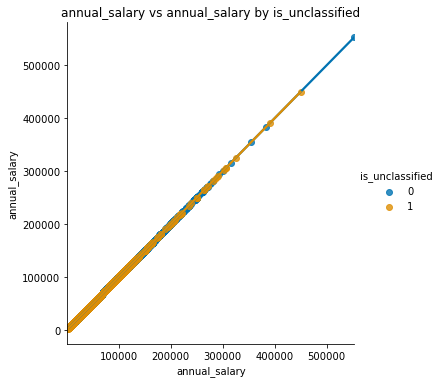

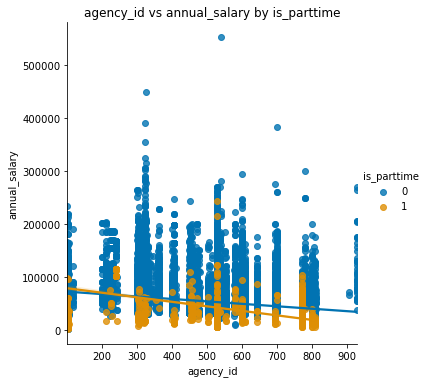

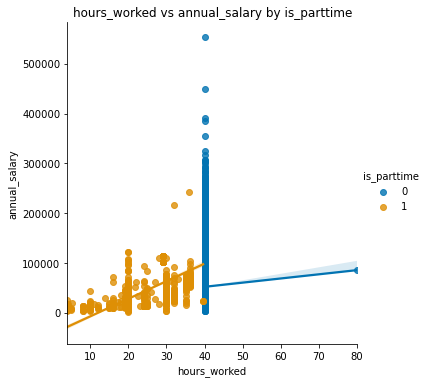

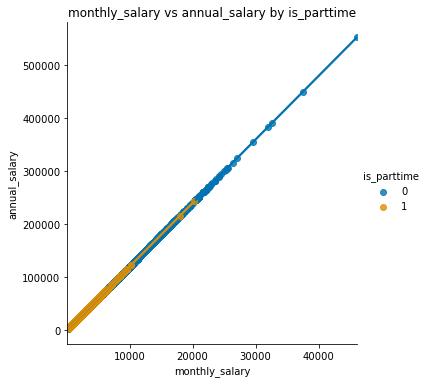

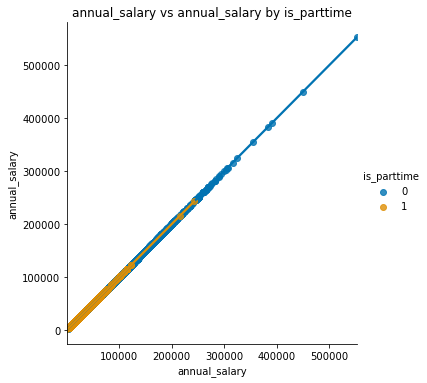

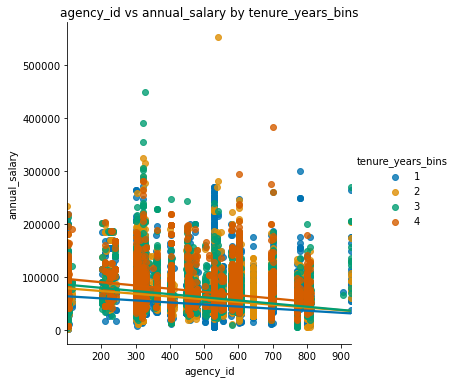

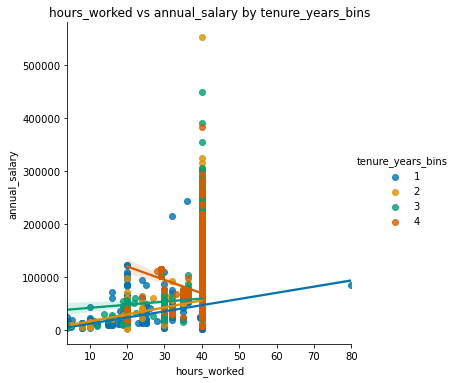

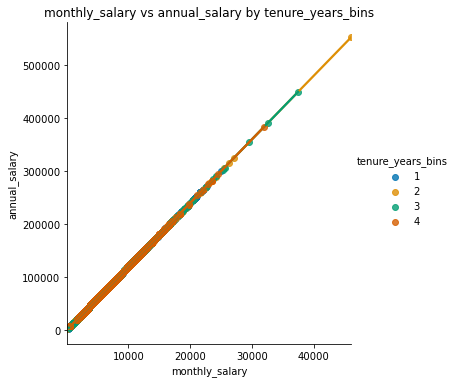

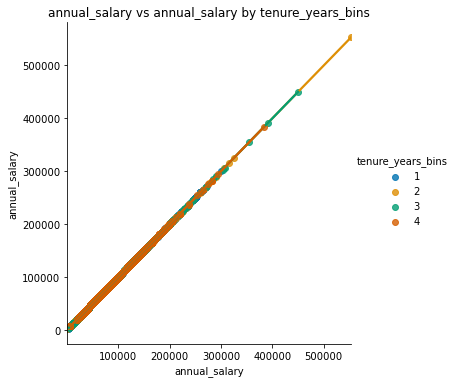

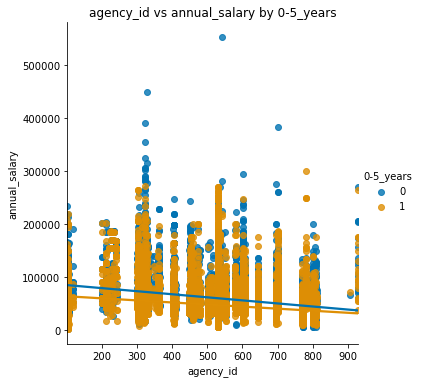

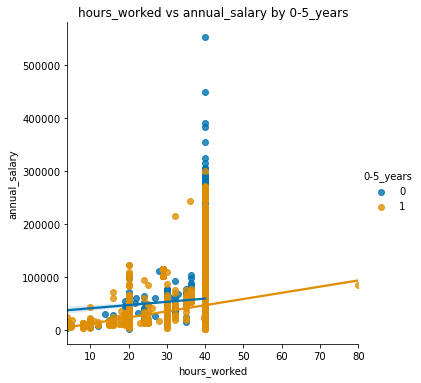

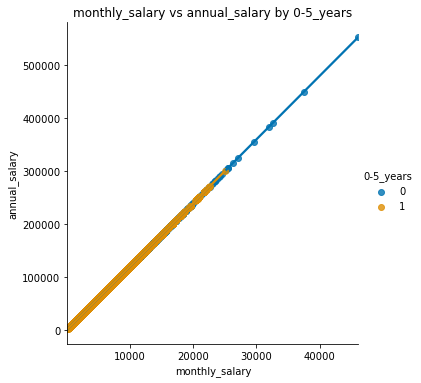

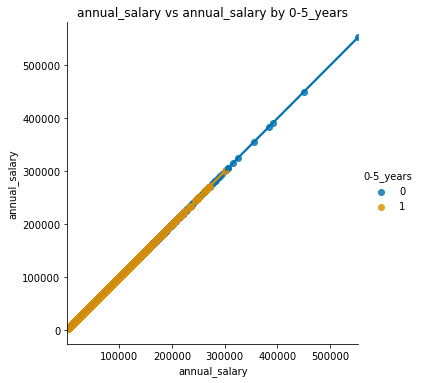

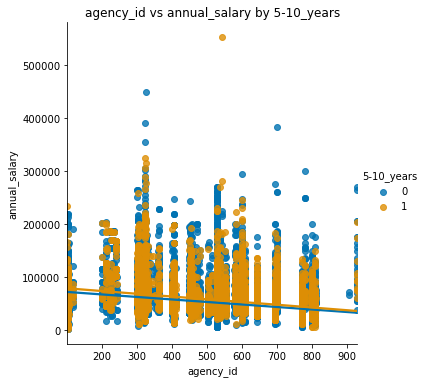

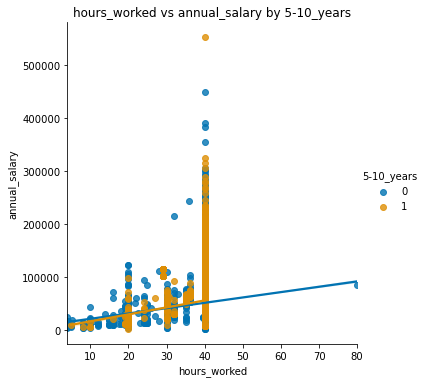

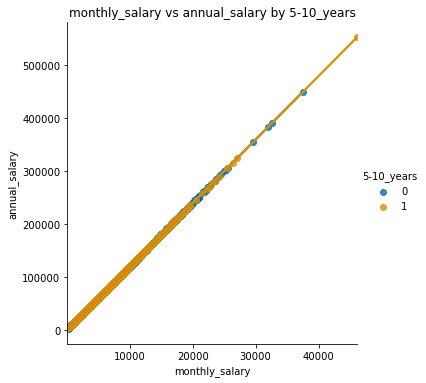

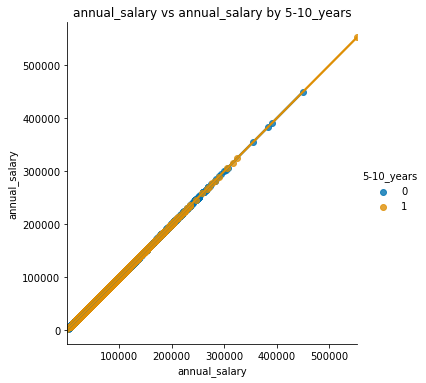

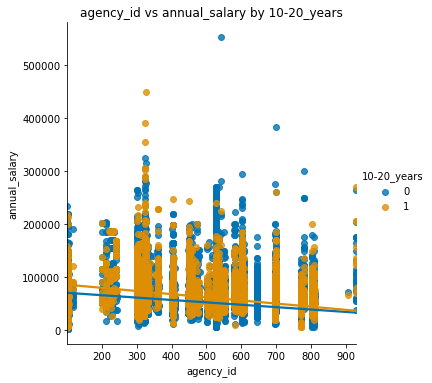

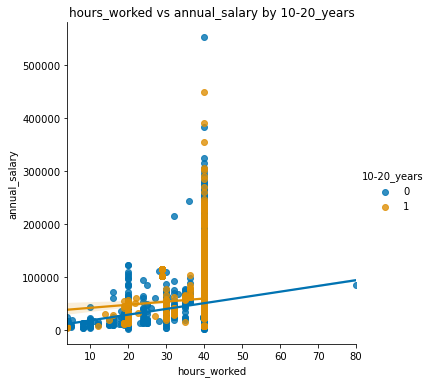

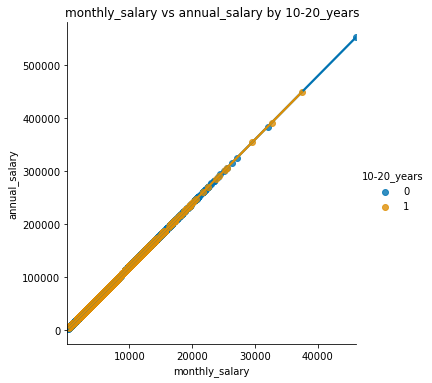

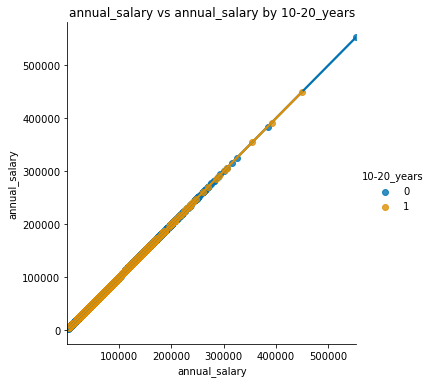

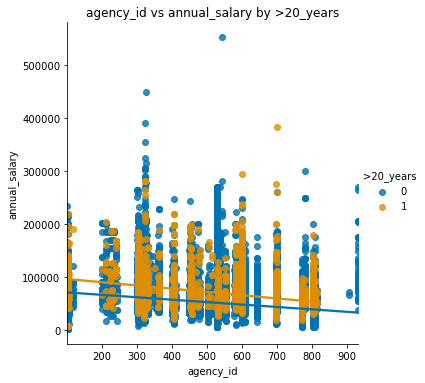

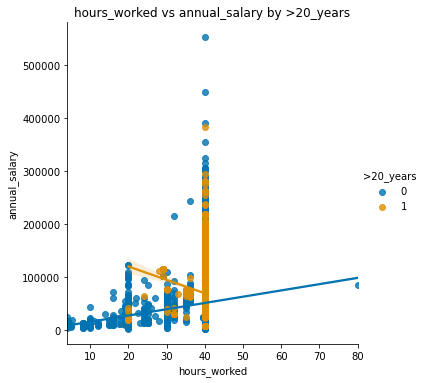

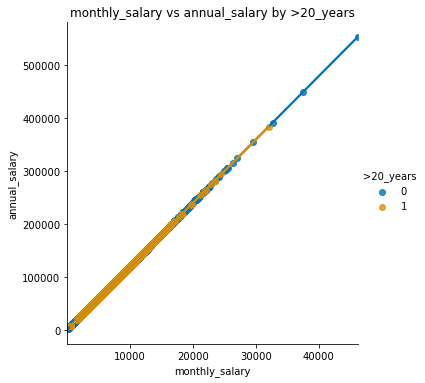

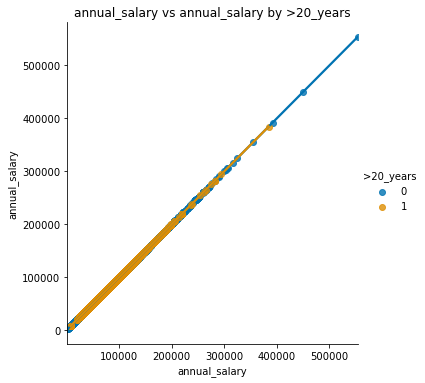

In [21]:
ex.explore_multivariate(train, 'annual_salary', cat_vars1, quant_vars1)

### Takeaways

- Highest annual salary for white employees is in agency 320
- Most employees work 40hours
- annual salary is derived from monthly salary
- Females have lower annual salaries than their male coworkers in the same department
- Highest annual salary for black employees is under 30,000
- Highest annual salary for hispanic employees is under 300,000
- All departments have people of color but non BIPOC have higher annual salaries
- Elected employees have higher salaries than non elected employees
- Employees who are Directors have higher annual salaries than those who are not
- Directors usually work full time hours
- Most Employees are classified 
- There are fewer part time employees than full time

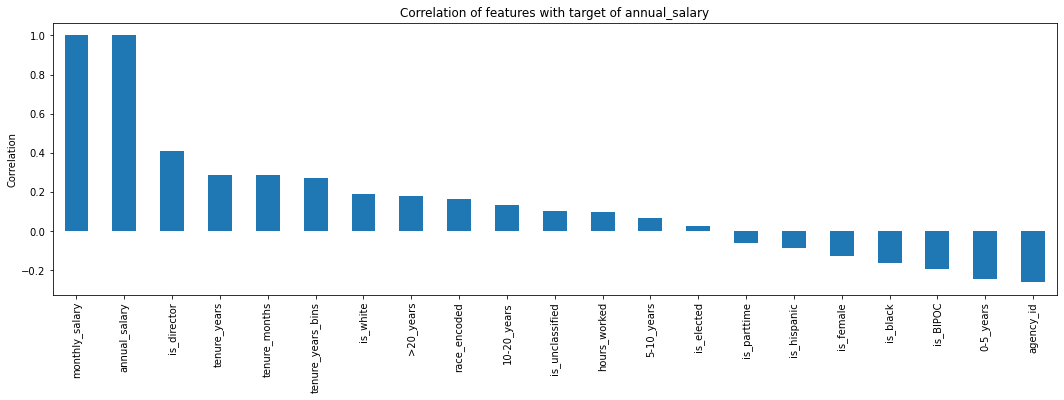

In [22]:
# visualize correlation of features with the target variable 
plt.figure(figsize=(15,8))
plt.ylabel('Correlation')
plt.title('Correlation of features with target of annual_salary')
train.corr().annual_salary.sort_values(ascending=False).plot(kind='bar', figsize=(18,5))
plt.show()

In [23]:
train.columns

Index(['agency_id', 'agency', 'lastname', 'firstname', 'title', 'race', 'sex',
       'emptype', 'hire_date', 'hours_worked', 'monthly_salary',
       'annual_salary', 'is_female', 'is_white', 'is_hispanic', 'is_black',
       'is_BIPOC', 'race_encoded', 'tenure_months', 'tenure_years',
       'is_elected', 'is_director', 'is_unclassified', 'is_parttime',
       'tenure_years_bins', '0-5_years', '5-10_years', '10-20_years',
       '>20_years'],
      dtype='object')

In [24]:
# selecting columns to visualize in heatmap
cols = ['agency_id', 'race', 'sex', 'emptype', 'annual_salary', 
       'is_female', 'is_white', 'is_hispanic', 'is_black',
       'is_BIPOC', 'race_encoded', 'tenure_months', 'tenure_years',
       'is_elected', 'is_director', 'is_unclassified', 'is_parttime',
       'tenure_years_bins', '0-5_years', '5-10_years', '10-20_years',
       '>20_years']

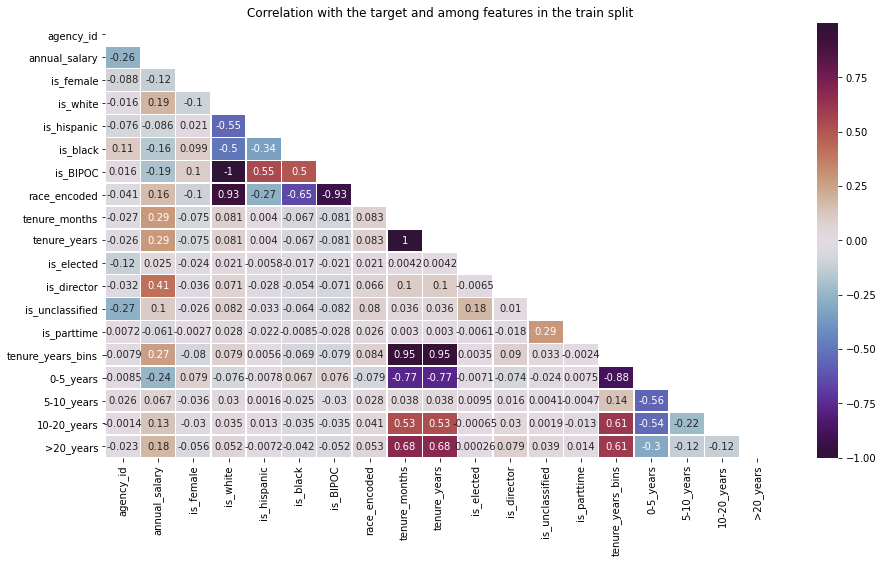

In [25]:
ex.create_heatmap(train, cols)

### Takeaways

- Highest correlation with target variable is 0.41 of is_director.
- Darker colors in the heatmap indicate higher correlation coefficient.
- Highest correlation among all variables is that of is_BIPOC vs is_white at -1.
- tenure_years and tenure_months are highly correlated with tenure_years_bins
- The tenure bins also seem to be highly correlated with tenure variables.
- race_encoded has a high correlation of 0.93 with is_white and is_BIPOC.


## Statistical Testing

Based on our EDA, we will be testing the following hypotheses:

- There is an association between gender and elected official status.
- There is an association between gender and director status.
- There is an association between race and elected official status.
- There is an association between race and director status.
- There is a significant correlation between is_director and annual_salary.
- There is a significant correlation between tenure_months and annual_salary.
- There is a significant difference in annual salary between BIPOC and white Texas government employees.
- Male employees have higher annual salaries than female employees.
- Elected officials have higher salaries.
- Unclassified employees have higher salaries than classified positions.


**For all statistical tests, a confidence level of 0.95 and an alpha of 0.05 will be used.**

### Gender vs is_elected

$H_0$: There is no association between gender and whether or not someone is an elected official.

$H_a$: There is an association between gender and elected official status.


In [26]:
# pandas crosstab to make a 'contingency' table
observed = pd.crosstab(train.sex, train.is_elected)
observed

is_elected,0,1
sex,,
FEMALE,46397,49
MALE,34492,110


In [27]:
# chi2_contingency returns 4 different values
chi2, p, degf, expected = stats.chi2_contingency(observed)


In [28]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[46397    49]
 [34492   110]]
---
Expected

[[46354    91]
 [34534    67]]
---

chi^2 = 44.6117
p     = 0.0000


- Since the p-value is less than our alpha of 0.05, we can reject the null hypothesis. We move forward with the alternative hypothesis: There is an association between gender and elected official status. 

### Gender vs is_director

$H_0$: There is no association between gender and whether or not someone is a director.

$H_a$: There is an association between gender and director status.

In [29]:
# crosstab to make a 'contingency' table
observed = pd.crosstab(train.sex, train.is_director)
observed

is_director,0,1
sex,,
FEMALE,45678,768
MALE,33668,934


In [30]:
# chi2_contingency returns 4 different values

chi2, p, degf, expected = stats.chi2_contingency(observed)

In [31]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[45678   768]
 [33668   934]]
---
Expected

[[45470   975]
 [33875   726]]
---

chi^2 = 104.9668
p     = 0.0000


- Since the p-value is less than our alpha of 0.05, we can reject the null hypothesis. We move forward with the alternative hypothesis: There is an association between gender and director status. 

#### is_BIPOC vs is_elected

$H_0$: There is no association between BIPOC and whether or not someone is an elected official.

$H_a$: There is an association between race and elected official status.

In [32]:
# crosstab to make a 'contingency' table
observed = pd.crosstab(train.is_BIPOC, train.is_elected)
observed

is_elected,0,1
is_BIPOC,,
0,36044,108
1,44845,51


In [33]:
# chi2_contingency returns 4 different values

chi2, p, degf, expected = stats.chi2_contingency(observed)

In [34]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[36044   108]
 [44845    51]]
---
Expected

[[36081    70]
 [44807    88]]
---

chi^2 = 34.1206
p     = 0.0000


- Since the p-value is less than our alpha of 0.05, we can reject the null hypothesis. We move forward with the alternative hypothesis: There is an association between race and elected official status. 

#### BIPOC vs is_director

$H_0$: There is no association between BIPOC and whether or not someone is a director of their department

$H_a$: There is an association between race and director status.

In [35]:
# crosstab to make a 'contingency' table
observed = pd.crosstab(train.is_BIPOC, train.is_director)
observed

is_director,0,1
is_BIPOC,,
0,34984,1168
1,44362,534


In [36]:
# chi2_contingency returns 4 different values

chi2, p, degf, expected = stats.chi2_contingency(observed)

In [37]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[34984  1168]
 [44362   534]]
---
Expected

[[35392   759]
 [43953   942]]
---

chi^2 = 404.9354
p     = 0.0000


- Since the p-value is less than our alpha of 0.05, we can reject the null hypothesis. We move forward with the alternative hypothesis: There is an association between race and director status.

#### Director Category vs. Annual Salary

- Pearson's Correlation Test

$H_0$: There is no significant correlation between being a director and annual salary.

$H_a$: There is a significant correlation between being a director and annual salary.

In [38]:
# run correlation test
corr, p = stats.pearsonr(train['is_director'], train.annual_salary)
corr, p

(0.41231928115326255, 0.0)

- Since the p-value is less than our alpha of 0.05, we can reject the null hypothesis. We move forward with the alternative hypothesis: There is a significant correlation between being a director and annual salary.

#### Months of Tenure vs. Annual Salary

- Pearson's Correlation Test

$H_0$: There is no significant correlation between tenure (in months) and annual salary.

$H_a$: There is a significant correlation between tenure (in months) and annual salary.

In [39]:
# run correlation test
corr, p = stats.pearsonr(train['tenure_months'], train.annual_salary)
corr, p

(0.28509496814591634, 0.0)

- Since the p-value is less than our alpha of 0.05, we can reject the null hypothesis. We move forward with the alternative hypothesis: There is a significant correlation between tenure (in months) and annual salary. 

#### BIPOC vs White: Annual Salary

BIPOC stands for Black, Indigenous, Person of color

- Independent t-test

$H_0$: There is no significant difference in annual salary based on if an employee is BIPOC or white.

$H_a$: There is a significant difference in annual salary based on if an employee is BIPOC or white.

- Verify assumptions

Normal distribution

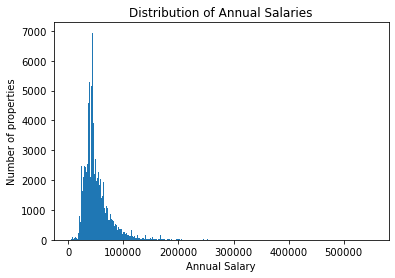

In [40]:
# plot distribution of tax values

plt.title('Distribution of Annual Salaries')
plt.xlabel('Annual Salary')
plt.ylabel('Number of properties')
plt.hist(train.annual_salary, bins=300)
plt.show()

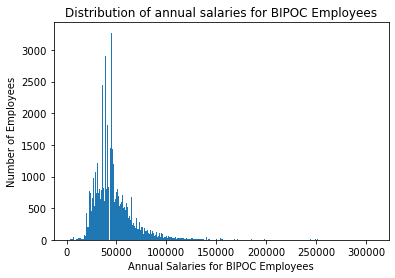

In [41]:
# plot distribution of annual salaries for BIPOC employees

bipoc_sal = train[train.is_BIPOC == 1].annual_salary
bipoc_sal.hist(bins=300)
plt.title('Distribution of annual salaries for BIPOC Employees')
plt.ylabel('Number of Employees')
plt.xlabel('Annual Salaries for BIPOC Employees')
plt.grid(False)
plt.show()

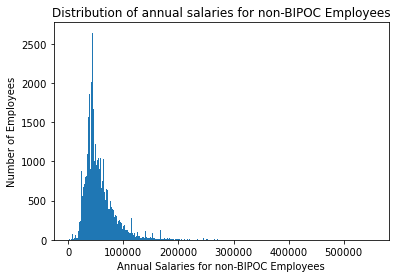

In [42]:
# plot distribution of annual salaries for non-BIPOC employees

bipoc_sal = train[train.is_BIPOC == 0].annual_salary
bipoc_sal.hist(bins=300)
plt.title('Distribution of annual salaries for non-BIPOC Employees')
plt.ylabel('Number of Employees')
plt.xlabel('Annual Salaries for non-BIPOC Employees')
plt.grid(False)
plt.show()

> The distributions look slightly right skewed because of outliers. However, if outliers were removed, we would see a more normal distribution. Since we have enough observations (more than 30), we can assume the distribution is normal based on CLT. 

In [43]:
# making our two sub group dataframes: bipoc and non-bipoc(white)

bipoc = train[train['is_BIPOC'] == 1]
non_bipoc = train[train['is_BIPOC'] == 0]

In [44]:
# run independent t-test 

t, p = stats.ttest_ind(non_bipoc.annual_salary, bipoc.annual_salary, equal_var = False)
t, p

(53.15936683135523, 0.0)

- Since the p-value is less than our alpha of 0.05, we can reject the null hypothesis. We move forward with the alternative hypothesis:  There is a significant difference in annual salary based on if an employee is BIPOC or white.

#### Male vs Female: Average Salary

- 2 sample 2 tailed t-test

$H_0$: Average salary of females == Average salary of males

$H_a$: Average salary of females is significantly different than Average salary of males

- Verify assumptions

    - Normal distribution
    - Equal variances

In [45]:
# set up our samples
sample1 = train[train.sex=='FEMALE'].annual_salary
sample2 = train[train.sex=='MALE'].annual_salary

# now let's take a look at the variance to verify the variance between the two samples
sample1.var(), sample2.var()

(532840192.1955485, 814917248.4519943)

- Since the variances are not equal, we will set equal_var = False in the t-test.

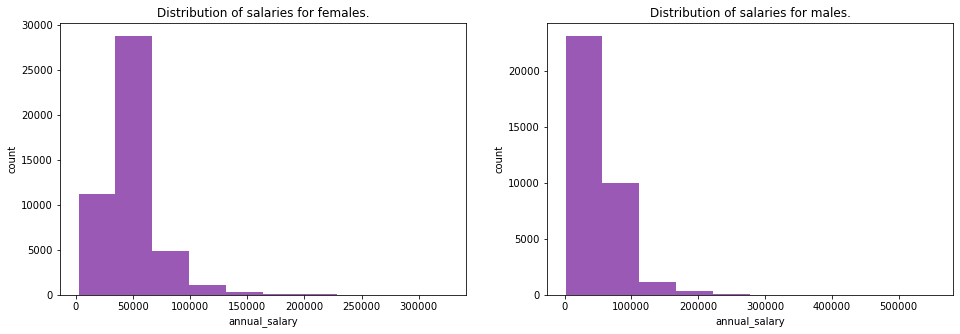

In [46]:
# take a look at salary distribution per gender
plt.figure(figsize=(16,5))
plt.subplot(121)
sample1.hist(color='#9b59b6')
plt.xlabel('annual_salary')
plt.ylabel('count')
plt.title('Distribution of salaries for females.')
plt.grid(False)
plt.subplot(122)
sample2.hist(color='#9b59b6')
plt.xlabel('annual_salary')
plt.ylabel('count')
plt.title('Distribution of salaries for males.')
plt.grid(False)

> The distributions look slightly right skewed. However, if outliers were removed, we would see a more normal distribution. Since we have enough observations (more than 30), we can assume the distribution is normal based on CLT.

In [47]:
# run t-test
t, p = stats.ttest_ind(sample1, sample2, equal_var=False)
t, p


(-34.60828268875567, 4.448013942637109e-260)

- Since the p-value is less than our alpha of 0.05, we can reject the null hypothesis. We move forward with the alternative hypothesis: Average salary of females is significantly different than Average salary of males.

#### Elected vs non elected: Average Salary

- 2 sample 2 tailed t-test

$H_0$: Average salary of non elected officials == Average salary of elected officials

$H_a$: Average salary of non elected officials < Average salary of elected officials

- Verify assumptions

Normal distribution
Equal variances

In [48]:
# find how many elected vs non elected
train.is_elected.value_counts()

0    80889
1      159
Name: is_elected, dtype: int64

- looks like most employees are not elected.

In [49]:
# set up our samples
elected = train[train.is_elected==1].annual_salary
non_elected = train[train.is_elected==0].annual_salary

# take a look at the variance
elected.var(), non_elected.var()

(6990687667.486143, 650741485.6095672)

- Since the variances are not equal, we will set equal_var = False in the t-test.

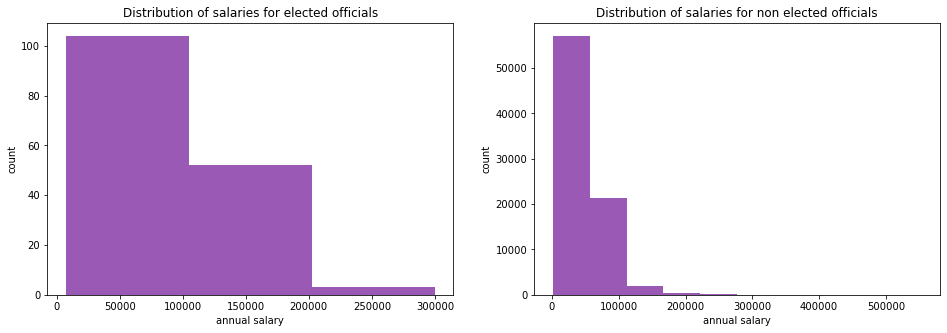

In [50]:
# visualize distributions
plt.figure(figsize=(16,5))
plt.subplot(121)
elected.hist(color='#9b59b6', bins =3)
plt.xlabel('annual salary')
plt.ylabel('count')
plt.title('Distribution of salaries for elected officials')
plt.grid(False)
plt.subplot(122)
non_elected.hist(color='#9b59b6')
plt.xlabel('annual salary')
plt.ylabel('count')
plt.title('Distribution of salaries for non elected officials')
plt.grid(False)

- The distributions look slightly right skewed due to some very high salaries. However, if outliers were removed, we would see a more normal distribution. Since we have enough observations (more than 30), we can assume the distribution is normal based on CLT.

In [51]:
# run t-test
t, p = stats.ttest_ind(non_elected, elected, equal_var=False)
t, p

(-2.2338357387065892, 0.02689723153279363)

- Since the p-value is less than our alpha of 0.05 and t<0, we can reject the null hypothesis. We move forward with the alternative hypothesis: Average salary of non elected officials is less than that of elected officials.

#### Classified vs Non Classified employees: Average Salary

- 2 sample 1 tailed t-test - p/2 will be considered

$H_0$: Average salary of employees with unclassified jobs == Average salary of employees with classified jobs

$H_a$: Average salary of employees with unclassified jobs < Average salary of employees with classified jobs

- Verify assumptions

    - Normal distribution

    - Equal variances

In [53]:
# set up our samples
classified = train[train.is_unclassified==0].annual_salary
unclassified = train[train.is_unclassified==1].annual_salary

classified.var(), unclassified.var()

(623327307.3812659, 1953827494.3648906)

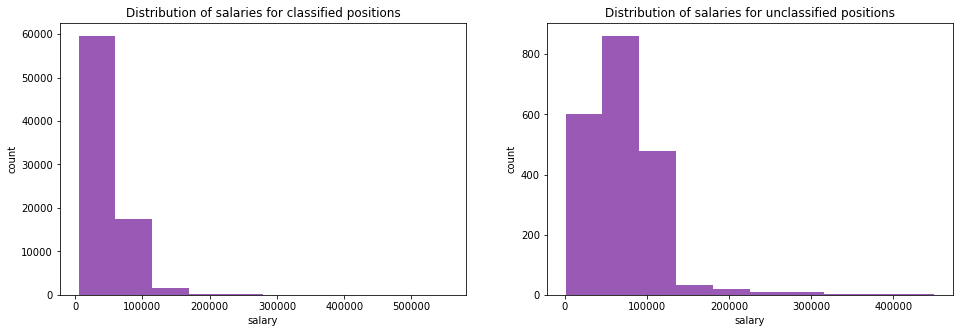

In [54]:
# take a look at salary distribution
plt.figure(figsize=(16,5))
plt.subplot(121)
classified.hist(color='#9b59b6')
plt.xlabel('salary')
plt.ylabel('count')
plt.title('Distribution of salaries for classified positions')
plt.grid(False)
plt.subplot(122)
unclassified.hist(color='#9b59b6')
plt.xlabel('salary')
plt.ylabel('count')
plt.title('Distribution of salaries for unclassified positions')
plt.grid(False)

- Since the variances are not equal, we will set equal_var = False in the t-test.

In [55]:
# run t-test
t, p = stats.ttest_ind(unclassified, classified, equal_var=False)
t, p

(17.39761168430389, 2.4918227028581886e-63)

In [56]:
alpha=0.05
(p/2 < alpha)  & (t < 0)

False

- Since the p/2 value is less than our alpha of 0.05 but t statistic is not less than 0, we fail to reject the null hypothesis. We move forward with the null hypothesis: Average salary of employees with unclassified jobs is not less than Average salary of employees with classified jobs

### Takeaways

Based on our hypothesis testing, we can conclude:

- There is an association between gender and elected official status.
- There is an association between gender and director status.
- There is an association between race and elected official status.
- There is an association between race and director status.
- There is a significant correlation between tenure (in months) and annual salary.
- There is a significant difference in annual salary based on if an employee is BIPOC or white.
- Average salary of females is significantly different than that of males.
- Average salary of non elected officials is less than that of elected officials.
- Average salary for unclassified jobs is not less than that for classified jobs.


### Scaling the features

Since tenure is numeric but not ordinal, we will scale the tenure variables to make sure the model does not rank one class higher than the other. We will use a min max scaler from our prepare script. This scaler will preserve the shape of the original distribution but it will transform features to values between 0 and 1.

Before we begin scaling we will assign our X and y variables in all our split dfs.

In [57]:
# assign X and y variables in all our split dfs
X_train = train[['agency_id', 'hours_worked','is_female', 'is_white', 
                'is_hispanic', 'is_black', 'is_BIPOC', 'race_encoded', 'tenure_months',
                'tenure_years', 'is_elected', 'is_director', 'is_unclassified', 'is_parttime', '0-5_years', '5-10_years', '10-20_years',
       '>20_years' ]]
y_train = train[['annual_salary']]

X_validate = validate[['agency_id', 'hours_worked','is_female', 'is_white', 
                'is_hispanic', 'is_black', 'is_BIPOC', 'race_encoded', 'tenure_months',
                'tenure_years', 'is_elected', 'is_director', 'is_unclassified', 'is_parttime', '0-5_years', '5-10_years', '10-20_years',
       '>20_years' ]]
y_validate = validate[['annual_salary']]

X_test = test[['agency_id', 'hours_worked','is_female', 'is_white', 
                'is_hispanic', 'is_black', 'is_BIPOC', 'race_encoded', 'tenure_months',
                'tenure_years', 'is_elected', 'is_director', 'is_unclassified', 'is_parttime','0-5_years', '5-10_years', '10-20_years',
       '>20_years' ]]
y_test = test[['annual_salary']]

In [58]:
# quick check of our split dfs
X_train.shape, X_validate.shape, X_test.shape

((81048, 18), (34736, 18), (28946, 18))

- All splits have the same number of splits so now we will proceed with scaling.

In [59]:
cols_to_scale = ['tenure_years', 'tenure_months']

In [60]:
# call scaler from prepare script
X_train[['tenure_years_scaled', 'tenure_months_scaled']], X_validate[['tenure_years_scaled', 'tenure_months_scaled']], X_test[['tenure_years_scaled', 'tenure_months_scaled']] = pr.min_max_scale(X_train, X_validate, X_test, cols_to_scale)

In [61]:
# check tenure years has been scaled
X_train.head()

,agency_id,hours_worked,is_female,is_white,is_hispanic,is_black,is_BIPOC,race_encoded,tenure_months,tenure_years,is_elected,is_director,is_unclassified,is_parttime,0-5_years,5-10_years,10-20_years,>20_years,tenure_years_scaled,tenure_months_scaled
125096,696,40.0,0,0,0,1,1,2,53,4.4,0,0,0,0,1,0,0,0,0.088353,0.088777
42845,529,40.0,1,0,0,0,1,1,10,0.8,0,0,0,0,1,0,0,0,0.016064,0.016750
117530,696,40.0,0,0,0,1,1,2,15,1.2,0,0,0,0,1,0,0,0,0.024096,0.025126
26227,405,40.0,0,1,0,0,0,5,141,11.8,0,0,0,0,0,0,1,0,0.236948,0.236181
113713,696,40.0,1,0,1,0,1,3,59,4.9,0,0,0,0,1,0,0,0,0.098394,0.098827


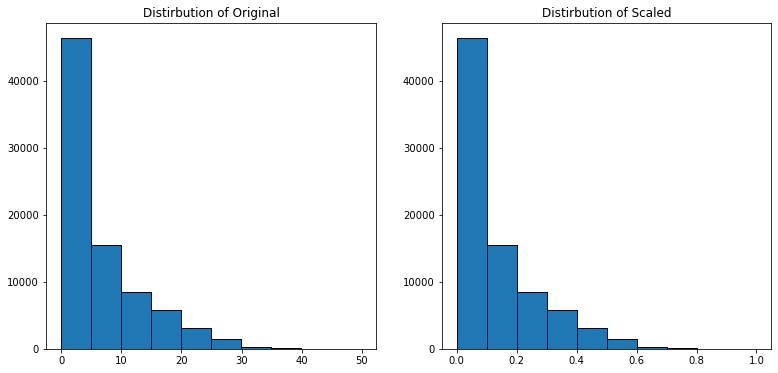

In [62]:
# plot original vs scaled distributions
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train.tenure_years, bins=10, ec='black')
plt.title('Distirbution of Original')
plt.subplot(122)
plt.hist(X_train.tenure_years_scaled,bins=10, ec='black')
plt.title('Distirbution of Scaled')
plt.show()

- As visualized above, the original distributions remain the same but the scaled values are between 0 and 1.

### Recursive Feature Elimination

We will call the RFE function from our explore script to find the top features to include in our models.

In [63]:
# call rfe function from explore script
features_to_use, feature_rankings = ex.select_rfe(X_train, y_train, 10, return_rankings=True)

In [64]:
features_to_use

['is_female',
 'is_hispanic',
 'is_black',
 'is_BIPOC',
 'is_director',
 'is_unclassified',
 'is_parttime',
 '0-5_years',
 '5-10_years',
 '>20_years']

- We will use features selected by RFE as well as agency_id since salaries vary by departments. This will help improve model performance. 

In [65]:
features = ['is_female',
 'is_hispanic',
 'is_black',
 'is_BIPOC',
 'is_director',
 'is_unclassified',
 'is_parttime',
 '0-5_years',
 '5-10_years',
 '>20_years']

In [66]:
### Establishing the Baseline

# 1. Predict mean annual 
sal_pred_mean = y_train.annual_salary.mean()
y_train['sal_pred_mean'] = sal_pred_mean
y_validate['sal_pred_mean'] = sal_pred_mean

# 2. Predict median tax value 
sal_pred_median = y_train.annual_salary.median()
y_train['sal_pred_median'] = sal_pred_median
y_validate['sal_pred_median'] = sal_pred_median

# 3. RMSE of tv_pred_mean
rmse_train = mean_squared_error(y_train.annual_salary, y_train.sal_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.annual_salary, y_validate.sal_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

# 4. RMSE of tv_pred_median
rmse_train1 = mean_squared_error(y_train.annual_salary, y_train.sal_pred_median) ** .5
rmse_validate1 = mean_squared_error(y_validate.annual_salary, y_validate.sal_pred_median) ** .5
print('-----------')
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train1, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate1, 5))

RMSE using Mean
Train/In-Sample:  25758.77625 
Validate/Out-of-Sample:  25431.1923
-----------
RMSE using Median
Train/In-Sample:  26727.62101 
Validate/Out-of-Sample:  26448.16247


In [67]:
# check drop off between train and validate rmse using mean
25758.77625 - 25431.1923

327.5839500000002

In [68]:
# check drop off between train and validate rmse using median
26727.62101 - 26448.16247

279.45853999999963

- The RMSE's using mean and median are quite close in value. The RMSE using median is higher but since there is a smaller drop off between RMSE for train and validate splits we will proceed with using RMSE using median as the baseline.

In [69]:
# create df to hold metrics
metrics_df = pd.DataFrame()

In [70]:
metrics_df = m.get_metrics(metrics_df, 'median_baseline',rmse_validate1,explained_variance_score(y_validate.annual_salary, y_validate.sal_pred_median))

In [71]:
metrics_df

,model,r^2_outofsample,rmse_outofsample
0,median_baseline,0.0,26448.162472


### Model 1: OLS Linear Regression

In [72]:
# create the model object

lm = LinearRegression(fit_intercept=True)

# fit the model to our training data. We must specify the column in y_train, since we have converted it to a dataframe from a series! 

# fit the thing using only the features we selected
lm.fit(X_train[features], y_train.annual_salary)

# predict train

y_train['sal_pred_lm'] = lm.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.annual_salary, y_train.sal_pred_lm) ** (1/2)

# predict validate
y_validate['sal_pred_lm'] = lm.predict(X_validate[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.annual_salary, y_validate.sal_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  21897.645378901583 
Validation/Out-of-Sample:  21675.00495243129


In [73]:
lm.intercept_

62716.403318979355

In [74]:
# coefficients of the model
lm.coef_

array([ -3772.9339308 , -11926.33056928, -14126.91084085,   5033.54897695,
        67465.10331652,  16918.65006014, -16602.71077194, -10964.56564833,
        -3533.52552282,   7414.3082238 ])

In [75]:
# look at the features and their coefficients
pd.Series(dict(zip(features, lm.coef_)))

is_female          -3772.933931
is_hispanic       -11926.330569
is_black          -14126.910841
is_BIPOC            5033.548977
is_director        67465.103317
is_unclassified    16918.650060
is_parttime       -16602.710772
0-5_years         -10964.565648
5-10_years         -3533.525523
>20_years           7414.308224
dtype: float64

## Takeaways

Based on our linear regression model, with all other variables held constant we can make the following deductions:

- A female employee will have a salary 3,772 USD less than a male employee.
- An employee who identifies as hispanic has an annual salary 11,926 USD less than a non hispanic employee.
- A Black employee will have an annual salary about 14,126 USD less than a non Black employee.
- A person of color will have an annual salary 5,033 USD higher.
- A director will earn 67,465 USD more than an employee who is not a director.
- An unclassified employee makes 16,918 USD more than a classified employee.
- A part time employee makes 16,602 USD less than a full time employee,
- An employee with 0-5 years tenure will make 10,964 USD less than those with longer tenures.
- An employee with 5-10 years tenure will make 3,533 USD less in annual salary than other employees.
- Employees with tenures longer than 20 years have an annual salary 7,414 USD higher than others.


Based on our model the regression equation would be:

annual_salary = 62716.403318979035 + (-3772.933931)`is_female` + (-11926.330569)`is_hispanic` + (-14126.910841)`is_black` + (5033.548977)`is_BIPOC` + (67465.103317)`is_director` + (16918.650060)`is_unclassified` + (-16602.710772)`is_parttime` + (-10964.565648)`0-5_years` + (-3533.525523)`5-10_years` + (7414.308224)`>20_years`

In [76]:
# add model to df
metrics_df = m.get_metrics(metrics_df, 'OLS lm',rmse_validate1,explained_variance_score(y_validate.annual_salary, y_validate.sal_pred_lm))

In [77]:
metrics_df

,model,r^2_outofsample,rmse_outofsample
0,median_baseline,0.000000,26448.162472
1,OLS lm,0.273651,26448.162472


### Model 2: Lasso Lars

In [78]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data using only selected features. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series
lars.fit(X_train[features], y_train.annual_salary)

# predict train
y_train['sal_pred_lars'] = lars.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.annual_salary, y_train.sal_pred_lars) ** 0.5

# predict validate
y_validate['sal_pred_lars'] = lars.predict(X_validate[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.annual_salary, y_validate.sal_pred_lars) ** 0.5

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  21941.666283846233 
Validation/Out-of-Sample:  21731.842116402717


In [79]:
# add model to df
metrics_df = m.get_metrics(metrics_df, 'LassoLars alpha 1',rmse_validate1,explained_variance_score(y_validate.annual_salary, y_validate.sal_pred_lars))

In [80]:
metrics_df

,model,r^2_outofsample,rmse_outofsample
0,median_baseline,0.000000,26448.162472
1,OLS lm,0.273651,26448.162472
2,LassoLars alpha 1,0.269828,26448.162472


### Model 3: Tweedie Regressor GLM

In [81]:
# create the model object
glm = TweedieRegressor(power=0, alpha=1)

# fit the model to our training data using only selected features. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series

glm.fit(X_train[features], y_train.annual_salary)

# predict train
y_train['sal_pred_glm'] = glm.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.annual_salary, y_train.sal_pred_glm) ** 0.5


# predict validate
y_validate['sal_pred_glm'] = glm.predict(X_validate[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.annual_salary, y_validate.sal_pred_glm) ** 0.5

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  25055.40343133055 
Validation/Out-of-Sample:  24728.082123615626


In [82]:
# add model to df
metrics_df = m.get_metrics(metrics_df, 'Tweedie GLM power 1',rmse_validate1,explained_variance_score(y_validate.annual_salary, y_validate.sal_pred_glm))

In [83]:
metrics_df

,model,r^2_outofsample,rmse_outofsample
0,median_baseline,0.000000,26448.162472
1,OLS lm,0.273651,26448.162472
2,LassoLars alpha 1,0.269828,26448.162472
3,Tweedie GLM power 1,0.054529,26448.162472


### Model 4: 2nd degree Polynomial Regression

In [84]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = pf.fit_transform(X_train[features])

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate[features])
X_test_degree2 = pf.transform(X_test[features])


In [85]:
#create the model object

pm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

# fit the thing

pm.fit(X_train_degree2, y_train.annual_salary)

# predict train

y_train['sal_pred_pm'] = pm.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.annual_salary, y_train.sal_pred_pm) ** (1/2)

# predict validate
y_validate['sal_pred_pm'] = pm.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.annual_salary, y_validate.sal_pred_pm) ** (1/2)

print("RMSE for PolynomialRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for PolynomialRegression
Training/In-Sample:  21733.024363506564 
Validation/Out-of-Sample:  21498.232956605912


In [86]:
# add model to df
metrics_df = m.get_metrics(metrics_df, 'PolyReg Model',rmse_validate1,explained_variance_score(y_validate.annual_salary, y_validate.sal_pred_pm))

In [87]:
metrics_df

,model,r^2_outofsample,rmse_outofsample
0,median_baseline,0.000000,26448.162472
1,OLS lm,0.273651,26448.162472
2,LassoLars alpha 1,0.269828,26448.162472
3,Tweedie GLM power 1,0.054529,26448.162472
4,PolyReg Model,0.285439,26448.162472


### Takeaways

- All models outpeform the baseline RMSE and R-squared.
- The best performing model is the 2nd degree polynomial regression model.

### Fit Best Performing Model on Test Split

In [88]:
# predict on test
y_test['sal_pred_pm'] = pm.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.annual_salary, y_test.sal_pred_pm) ** 0.5
print("RMSE for Model using PolynomialRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for Model using PolynomialRegression
Out-of-Sample Performance:  21302.474105099678


In [89]:
# add test model to df
metrics_df = m.get_metrics(metrics_df, 'Test',rmse_test,explained_variance_score(y_test.annual_salary, y_test.sal_pred_pm))

In [90]:
metrics_df

,model,r^2_outofsample,rmse_outofsample
0,median_baseline,0.000000,26448.162472
1,OLS lm,0.273651,26448.162472
2,LassoLars alpha 1,0.269828,26448.162472
3,Tweedie GLM power 1,0.054529,26448.162472
4,PolyReg Model,0.285439,26448.162472
5,Test,0.309146,21302.474105


### Takeaways

Our Model has the best performance on the test split. This indicates that the model was not overfit. The Polynomial Regresion Model on test split has RMSE of 21301.188522 USD and R squared of 0.309. This means our model was off in salary prediction by about 21,000 USD and almost 31% of the variance in the data can be explained by our model.

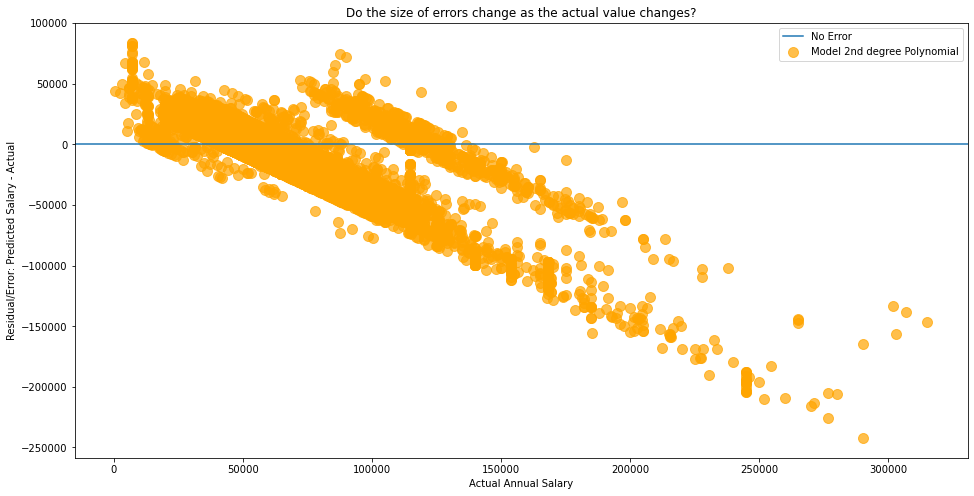

In [91]:
# plot the residuals for the best performing model

plt.figure(figsize=(16,8))
plt.axhline(label="No Error")

plt.scatter(y_validate.annual_salary, y_validate.sal_pred_pm - y_validate.annual_salary, 
            alpha=.7, color="orange", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Annual Salary")
plt.ylabel("Residual/Error: Predicted Salary - Actual")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()

In [111]:
train.shape

(81048, 29)

In [113]:
# take a look at predictions
y_train.sal_pred_pm.head()

125096    40866.649902
42845     54195.290527
117530    40866.649902
26227     64816.337402
113713    41917.790527
Name: sal_pred_pm, dtype: float64

In [114]:
# check shape
y_train.sal_pred_pm.shape, y_validate.sal_pred_pm.shape

((81048,), (34736,))

In [115]:
# create dataframes for each df prediction
train_pred = pd.DataFrame(y_train.sal_pred_pm)
val_pred = pd.DataFrame(y_validate.sal_pred_pm)
# test_pred = pd.DataFrame(y_test.sal_pred_pm)

In [135]:
# combine
frames = [train_pred, val_pred]

model_pred = pd.concat(frames)

In [136]:
model_pred = model_pred.reset_index()

In [137]:
model_pred.head()

,index,sal_pred_pm
0,125096,40866.649902
1,42845,54195.290527
2,117530,40866.649902
3,26227,64816.337402
4,113713,41917.790527


In [138]:
# verify shape
model_pred.shape

(115784, 2)

In [139]:
# to csv for tableau
model_pred.to_csv('model_pred.csv')

### Takeaways

- The residuals seem to be mostly around the no error horizontal line.
- The residuals have a pattern which implies our model is missing something. 
    - This might be due to the outliers since we did not have enough training data for extremely high salaries.
- The residuals are concentrated around lower range salaries which is what we observed in our original data.
- The residuals are much larger after annual salary is higher than 150,000.
    - This is expected because we have very few observations for very high salaries so the model cannot predict such extreme values as well.


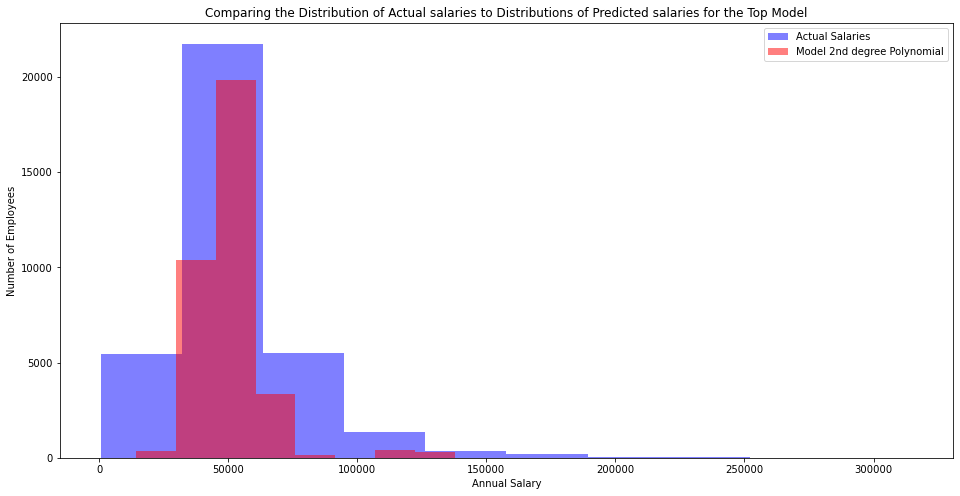

In [92]:
# plot to visualize actual vs predicted values
plt.figure(figsize=(16,8))
plt.hist(y_validate.annual_salary, color='blue', alpha=.5, label="Actual Salaries")
plt.hist(y_validate.sal_pred_pm, color='red', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Annual Salary")
plt.ylabel("Number of Employees")
plt.title("Comparing the Distribution of Actual salaries to Distributions of Predicted salaries for the Top Model")
plt.legend()
plt.show()

### Takeaways

- The distribution of the model is quite similar to the actual distribution but the spread of the model is less than the actual data.
- The model seems to be performing best around the mean annual salary and performance decreases above and below the 50,000 annual salary point.

## Conclusions and Next Steps

- Our best performing model uses the 2nd degree Polynomial Regression Algorithm. 
- The best model has an RMSE of 21301.188522 USD and R-squared of 0.309 .
- All our models beat the baseline RMSE and R-squared.
- Our model misses extreme values on the upper and lower end.
- If we had more time, we would like to implement the following ways to improve model performance:
    - collect more data for upper and lower end extreme values
    - create separate models to predict extreme salary values
    - look at past employee salary history to predict trends in compensation